# Part 2: Fund Movement Prediction

In [1]:
import calendar
from datetime import datetime
from itertools import product
import logging
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
import warnings

/Users/air50/Documents/k-business-analyst-project/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.filterwarnings("ignore")
# Set the logging level to ERROR
logging.getLogger('fbprophet').setLevel(logging.ERROR)


In [3]:
# Import the data 
statements_df=pd.read_csv('data/reconciled_card_data.csv')
business_df=pd.read_csv('data/business_kpi.csv')
statements_df['payment_date']=pd.to_datetime(statements_df['payment_date']).dt.date
statements_df['payment_date']=statements_df['payment_date'].fillna(statements_df['statement_end_date'])
statements_df.loc[statements_df['payment_date_reconcile']=='outstanding','payment_date_reconcile']=pd.NaT

## 1. EDA: credit card custumers and fund movements

The main independent and not transformed variables to be explored are: 
* `total_payment_collected` (it is transformed, but for this exercice there is no difference between domestic and international expense)
* `total_refunds`
* `total_purchases`
* `fee_amount`

These can later be added to compute the outstanding_balance, net_amount, total_debits, etc...

To begin, let's limit this EDA to those business that at least have 22 issued statements. (Since 22 * 0.2 * 7 =30 days)

In [4]:
# Filter the df
statement_count = (
    statements_df.groupby("business_id")
    .size()
    .reset_index(name="statements_count")
    .sort_values(by=["statements_count"], ascending=False)
)
target_business = statement_count[statement_count["statements_count"] >= 22]
statements_df_target_business = pd.merge(
    target_business, statements_df, on="business_id"
)
target_business

,business_id,statements_count
2,cl81xm5ze01001kx8kg53hob3,190
7,cl8af5bmp19891kx3wlkp2825,107
18,cl9rk0p090000ye1kuocy1ylx,49
5,cl83libcm71791nx2kmuehklu,32
3,cl823ggqb18681nww46j6v2kf,30
4,cl83l1qre64701lwuykh8gi0y,30
8,cl8jb9bog03311lx6vzqbhsrd,30
9,cl8khb2qs11621mx5wkbus530,29
6,cl8978e5209211lxatoukqp7b,29
0,cl81p742620381lycqw0xl7sf,28


### Time series representation

In [5]:
def time_series_data(
    business: str, statements_df_target_business: pd.DataFrame
) -> pd.DataFrame:
    business_df = statements_df_target_business[
        statements_df_target_business["business_id"] == business
    ]
    plot_df = business_df.copy()
    return plot_df


def plot_time_series(
    time_series_business: pd.DataFrame, business: str, min_date: str, max_date: str
) -> go.Figure:
    fig2 = go.Figure()
    metrics = [
        "total_purchases",
        "total_payment_collected",
        "fee_amount",
        "total_refunds",
        "outstanding_balance_recon",
    ]
    # Create a mapping between quarters and colors
    quarter_color_mapping = ["#F5F5F5", "#E0E0E0", "#CCCCCC", "#B8B8B8"]
    color_discrete_sequence = ["#4169E1", "#228B22", "#FF6347", "#DAA520", "#9370DB"]

    for i, metric in enumerate(metrics):
        trace_opacity = 0.2 if metric == "outstanding_balance_recon" else 1.0
        trace_dash = "dash" if metric == "outstanding_balance_recon" else "solid"
        trace_x = (
            time_series_business["statement_end_date"]
            if metric != "total_payment_collected"
            else time_series_business["payment_date"]
        )
        fig2.add_trace(
            go.Scatter(
                x=trace_x,
                y=time_series_business[metric],
                mode="lines",
                name=metric,
                line=dict(color=color_discrete_sequence[i], dash=trace_dash),
                opacity=trace_opacity,
            )
        )

    # Add shapes to highlight each quarter
    min_date_dt = datetime.strptime(min_date, "%Y-%m-%d")
    max_date_dt = datetime.strptime(max_date, "%Y-%m-%d")
    quarters = pd.date_range(
        start=f"{min_date_dt.year-1}-12-31", end=f"{max_date_dt.year+1}-01-01", freq="Q"
    )
    for i, quarter in enumerate(quarters):
        quarter_start = quarters[i - 1] if i > 0 else min_date_dt
        quarter_end = quarter
        quarter_color = quarter_color_mapping[
            i % len(quarter_color_mapping)
        ]  # Cycling through colors
        fig2.add_shape(
            type="rect",
            xref="x",
            yref="paper",
            x0=quarter_start,
            y0=0,
            x1=quarter_end,
            y1=1,
            fillcolor=quarter_color,
            opacity=0.35,
            layer="below",
            line=dict(width=0),
        )

    # Update layout for better readability
    fig2.update_layout(
        title=business,
        xaxis_title="Date",
        xaxis=dict(
            tickmode="linear",
            dtick=14 * 24 * 60 * 60 * 1000,
            range=[min_date, max_date],
        ),
        yaxis_title="Value ($)",
        yaxis_tickprefix="$",
        yaxis_tickformat=",",
        margin=dict(l=10, r=10, t=35, b=20),
        legend=dict(
            orientation="h", yanchor="bottom", y=-0.30, xanchor="center", x=0.5
        ),
    )

    return fig2


# Create a time series line plot
min_date = statements_df_target_business["statement_end_date"].min()
max_date = statements_df_target_business["statement_end_date"].max()
for business in target_business["business_id"].to_list():
    business_time_series = time_series_data(business, statements_df_target_business)
    plot_figure = plot_time_series(business_time_series, business, min_date, max_date)
    plot_figure.show()

### Parallel categories analysis

In [6]:
# Function to tell if the date
def get_week_of_month(date: pd.DatetimeIndex) -> [str, str]:
    year, month = date.year, date.month
    first_day_weekday = calendar.weekday(year, month, 1)
    week_month = min((date.day - 1) // 7 + 1, 4)
    week_calendar_number = (date.day + first_day_weekday - 1) // 7 + 1
    return f"W{week_month}", f"W{week_calendar_number}"


# Create time series features
def create_features(
    data_frame: pd.DataFrame, date_column: str, label
) -> [pd.DataFrame, pd.Series]:
    # Make temp copy of the df
    df = data_frame.copy()
    df["date"] = pd.to_datetime(df[date_column])
    df["dayofweek"] = df["date"].dt.dayofweek
    df["weekday"] = df["date"].dt.day_name()
    df["quarter"] = df["date"].apply(lambda x: f"Q{x.quarter}")
    df["month"] = df["date"].dt.month
    df["dayofmonth"] = df["date"].dt.day
    df["weekofyear"] = df["date"].dt.isocalendar().week
    df[["weekquarter", "weekofmonth"]] = df.apply(
        lambda x: get_week_of_month(x["date"]), axis=1, result_type="expand"
    )
    categorical_breakdown_date = df[
        [
            "dayofweek",
            "weekday",
            "quarter",
            "month",
            "dayofmonth",
            "weekofyear",
            "weekofmonth",
            "weekquarter",
            label,
            "business_id",
        ]
    ]
    return categorical_breakdown_date




In [7]:
features_and_target = create_features(
    statements_df, "statement_end_date", "total_purchases"
)
target_df = features_and_target[features_and_target["total_purchases"] > 0]
quarter_dim = go.parcats.Dimension(
    values=target_df["quarter"],
    categoryorder="category ascending",
    label="Quarter",
)
month_dim = go.parcats.Dimension(
    values=target_df["month"],
    categoryorder="category ascending",
    label="Month",
)
weekofmonth_dim = go.parcats.Dimension(
    values=target_df["weekofmonth"],
    categoryorder="category ascending",
    label="Week of month",
)
weekquarter_dim = go.parcats.Dimension(
    values=target_df["weekquarter"],
    categoryorder="category ascending",
    label="Week quarter",
)
weekday_dim = go.parcats.Dimension(
    values=target_df["dayofweek"],
    categoryarray=list(range(7)),
    label="Week day",
    ticktext=[
        "Mon",
        "Tue",
        "Wed",
        "Thu",
        "Wed",
        "Fri",
        "Sat",
        "Sun",
    ],
)
fig1 = go.Figure(
    data=[
        go.Parcats(
            dimensions=[
                month_dim,
                quarter_dim,
                weekofmonth_dim,
                weekquarter_dim,
                weekday_dim,
            ]
        )
    ]
)
fig1.update_layout(
    title='Total purchases: Fund movement',
    margin=dict(l=10, r=30, t=40, b=20),
)

In [8]:
features_and_target = create_features(
    statements_df, "payment_date", "total_payment_collected"
)
target_df = features_and_target[features_and_target["total_payment_collected"] > 0]
quarter_dim = go.parcats.Dimension(
    values=target_df["quarter"],
    categoryorder="category ascending",
    label="Quarter",
)
month_dim = go.parcats.Dimension(
    values=target_df["month"],
    categoryorder="category ascending",
    label="Month",
)
weekofmonth_dim = go.parcats.Dimension(
    values=target_df["weekofmonth"],
    categoryorder="category ascending",
    label="Week of month",
)
weekquarter_dim = go.parcats.Dimension(
    values=target_df["weekquarter"],
    categoryorder="category ascending",
    label="Week quarter",
)
weekday_dim = go.parcats.Dimension(
    values=target_df["dayofweek"],
    categoryarray=list(range(7)),
    label="Week day",
    ticktext=[
        "Mon",
        "Tue",
        "Wed",
        "Thu",
        "Wed",
        "Fri",
        "Sat",
        "Sun",
    ],
)
fig2 = go.Figure(
    data=[
        go.Parcats(
            dimensions=[
                month_dim,
                quarter_dim,
                weekofmonth_dim,
                weekquarter_dim,
                weekday_dim,
            ]
        )
    ]
)
fig2.update_layout(
    title='Payment colleted: Fund movement',
    margin=dict(l=10, r=30, t=40, b=20),
)
fig1.show()
fig2.show()

In [9]:
def plot_parallel_categories(
    statements_df_target_business: pd.DataFrame, business: str, currency_variable
) -> go.Figure:
    target_df = statements_df_target_business[
        statements_df_target_business["business_id"] == business
    ]
    target_df = target_df[target_df[currency_variable] > 0]
    quarter_dim = go.parcats.Dimension(
        values=target_df["quarter"],
        categoryorder="category ascending",
        label="Quarter",
    )
    month_dim = go.parcats.Dimension(
        values=target_df["month"],
        categoryorder="category ascending",
        label="Month",
    )
    weekofmonth_dim = go.parcats.Dimension(
        values=target_df["weekofmonth"],
        categoryorder="category ascending",
        label="Week of month",
    )
    weekquarter_dim = go.parcats.Dimension(
        values=target_df["weekquarter"],
        categoryorder="category ascending",
        label="Week quarter",
    )
    weekday_dim = go.parcats.Dimension(
        values=target_df["dayofweek"],
        categoryorder="category ascending",
        label="Week day",
    )
    fig = go.Figure(
        data=[
            go.Parcats(
                dimensions=[
                    month_dim,
                    quarter_dim,
                    weekofmonth_dim,
                    weekquarter_dim,
                    weekday_dim,
                ],
                # line=dict(
                #     color=target_df["total_purchases"],
                #     colorbar=dict(
                #         title="Total Purchases",
                #     ),
                #     cmin=0,
                #     cmax=5000,
                # ),
            )
        ]
    )
    fig.update_layout(
        title=f"{business}: {currency_variable}",
        margin=dict(l=10, r=30, t=40, b=20),
    )
    return fig


features_and_target = create_features(
    statements_df, "statement_end_date", "total_purchases"
)
for business in target_business["business_id"].to_list():
    plot_figure = plot_parallel_categories(features_and_target, business, "total_purchases")
    plot_figure.show()

In [10]:
features_and_target = create_features(
    statements_df, "payment_date", "total_payment_collected"
)
for business in target_business["business_id"].to_list():
    plot_figure = plot_parallel_categories(features_and_target, business, "total_payment_collected")
    plot_figure.show()

In [11]:
features_and_target = create_features(
    statements_df, "statement_end_date", "total_purchases"
)
days = {
    "Mon": "Monday",
    "Tue": "Tuesday",
    "Wed": "Wednesday",
    "Thu": "Thursday",
    "Fri": "Friday",
    "Sat": "Saturday",
    "Sun": "Sunday",
}
fig3 = go.Figure()
for key, value in days.items():
    x_trace = features_and_target.loc[
        features_and_target["weekday"] == value, "weekquarter"
    ]
    y_trace = features_and_target.loc[
        features_and_target["weekday"] == value, "total_purchases"
    ]
    fig3.add_trace(
        go.Box(
            y=y_trace,
            x=x_trace,
            name=key,
            boxpoints="all",
        )
    )
fig3.update_layout(
    yaxis_title="total_purchases", boxmode="group", yaxis_range=[-1000, 20000],
    margin=dict(l=10, r=30, t=40, b=20),
)
fig3.show()

In [12]:
features_and_target = create_features(
    statements_df, "payment_date", "total_payment_collected"
)
fig3 = go.Figure()
for key, value in days.items():
    x_trace = features_and_target.loc[
        features_and_target["weekday"] == value, "weekquarter"
    ]
    y_trace = features_and_target.loc[
        features_and_target["weekday"] == value, "total_payment_collected"
    ]
    fig3.add_trace(
        go.Box(
            y=y_trace,
            x=x_trace,
            name=key,
            boxpoints="all",
        )
    )
fig3.update_layout(
    yaxis_title="total_payment_collected",
    boxmode="group",
    yaxis_range=[-1000, 20000],
    margin=dict(l=10, r=30, t=40, b=20),
)
fig3.show()

### Takeaways: 
* Out of 58 businesses, only 13 have more than 20 issued statements.
* Companies exhibit varying expenditure levels, showing no uniformity in spending across different businesses.
* Spending habits also differ among companies. For example, some companies experience a more significant fund movement in Q4 compared to Q1, and vice versa.
*The issuance of statements is inconsistent, both within individual companies and across various businesses.
* Overall, fund movement tends to increase towards the end of the month and, in some cases, peaks towards the middle of the week.

## 2. Fund movement prediction

Doing customer segmentation could help to Having business metadata would help create customer segmentation to explore common patterns among similar businesses. 
Part of the code is an adaptation from this [Kaggle notebook](https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet-yt/notebook)

### LSTM 
1. Compute time deltas.
2. Stadarize currency variable.
3. Capture dummy data such as the quarter, week of the month and day. 
5. Train/split and fit model
4. Tune hyperparameters, mainly the autoregresive points.
5. Do the predictions and 


### Prophet
1. Keep a consistency frequency sample: remove datapoints.
2. Train/split
3. Add the effect of a 2 week period
4. Get metrics
5. Forecast

Let's do a model for each business and for both the total_purchases and total_payment_collected.

In [13]:
# Consistent frequency sample
statements_df_target_business["statement_start_date"] = pd.to_datetime(
    statements_df_target_business["statement_start_date"]
)
statements_df_target_business["statement_end_date"] = pd.to_datetime(
    statements_df_target_business["statement_end_date"]
)
date_difference= (
    statements_df_target_business["statement_end_date"]
    - statements_df_target_business["statement_start_date"]
)

statements_df_target_business["sampling_freq"]=date_difference.dt.days

In [14]:
# Calculates MAPE given y_true and y_pred
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    # Calculate MAPE, set 100% for cases where y_true is 0
    mape = np.zeros_like(y_true, dtype=float)
    mape[mask] = np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]) * 100
    mape[~mask] = 100  # Set 100% where y_true is 0
    return np.mean(mape)



def get_prophet_hyperparameters(business_id) -> pd.DataFrame:
    # Create the dataframe to tune the hyper parameters
    columns = ["weekly_seasonality", "fourier_order", "2week_seasonality", "MAE"]
    weekly_seasonality_values = [False]
    fourier_order_values = list(range(9, 11))  # integers from 3 to 10
    two_week_seasonality_values = [True]
    combinations = product(
        weekly_seasonality_values, fourier_order_values, two_week_seasonality_values
    )
    # Create a list of dictionaries
    data = [dict(zip(columns, combo)) for combo in combinations]
    # Create a DataFrame from the list of dictionaries
    df = pd.DataFrame(data)
    df['business_id']=business_id
    return df


def prophet_model_wrapper(train_df, test_df, order, w_sesonality, two_week_sesonality):
    m = Prophet(weekly_seasonality=w_sesonality)
    if two_week_sesonality:
        m.add_seasonality(name="2week", period=15, fourier_order=order)
    m.fit(train_df)
    forecast = m.predict(test_df)
    # Cumpute errors
    MAE = mean_absolute_percentage_error(y_true=test_df["y"], y_pred=forecast["yhat"])
    return MAE, m

In [15]:
def prophet_business_models(business_id, statements_df_target_business, fit_details):
    business_df = statements_df_target_business[
        statements_df_target_business["business_id"] == business_id
    ]
    # Filter the dataframe to have a consistent sampling
    sampling_mode = business_df["sampling_freq"].mode()[0]
    business_df_filtered = business_df[business_df["sampling_freq"] == sampling_mode]
    # Do the train/test split:  80% train and 20% test
    break_point = round(business_df_filtered.shape[0] * 0.8)
    business_df_filtered_train = business_df_filtered.iloc[0:break_point].copy()
    business_df_filtered_test = business_df_filtered.iloc[break_point:].copy()
    # Actually fit the model
    business_df_filtered_train = business_df_filtered_train.reset_index().rename(
        columns={"statement_end_date": "ds", "total_purchases": "y"}
    )
    business_df_filtered_test = business_df_filtered_test.reset_index().rename(
        columns={"statement_end_date": "ds", "total_purchases": "y"}
    )
    # Compute the optimal fourier order
    hyper_parameters = get_prophet_hyperparameters(business_id)
    hyper_parameters["MAE"] = hyper_parameters.apply(
        lambda x: prophet_model_wrapper(
            business_df_filtered_train,
            business_df_filtered_test,
            x["fourier_order"],
            x["weekly_seasonality"],
            x["2week_seasonality"],
        )[0],
        axis=1,
    )
    best_fit_values = hyper_parameters.loc[hyper_parameters["MAE"].idxmin()]
    MAE, m = prophet_model_wrapper(
        business_df_filtered_train,
        business_df_filtered_test,
        best_fit_values["fourier_order"],
        best_fit_values["weekly_seasonality"],
        best_fit_values["2week_seasonality"],
    )
    # Predict futures
    forecast_periods=int(30/sampling_mode)+1
    future = m.make_future_dataframe(periods=forecast_periods, freq=f"{sampling_mode}D")
    forecast = m.predict(future)
    fig, ax = plt.subplots(figsize=(15, 5))
    fig = m.plot(forecast, ax=ax)
    ax.set_title(f"{business_id}: Forecast")
    plt.show()
    print(f"Mean absolute error of {MAE}")
    if fit_details:
        # Plot components
        fig= m.plot_components(forecast)
        ax=fig.axes
        ax[0].set_title(f"{business_id}: Components")
        plt.show()
        # Plot the forecast with the actuals
        fig, ax = plt.subplots(figsize=(15, 5))
        ax.scatter(
            business_df_filtered_test["ds"], business_df_filtered_test["y"], color="r"
        )
        forecast = m.predict(business_df_filtered_test)
        fig = m.plot(forecast, ax=ax)
        ax.set_title(f"{business_id}: Test split")
        plt.show()

13:08:42 - cmdstanpy - INFO - Chain [1] start processing
13:08:42 - cmdstanpy - INFO - Chain [1] done processing
13:08:42 - cmdstanpy - INFO - Chain [1] start processing
13:08:42 - cmdstanpy - INFO - Chain [1] done processing
13:08:43 - cmdstanpy - INFO - Chain [1] start processing
13:08:43 - cmdstanpy - INFO - Chain [1] done processing


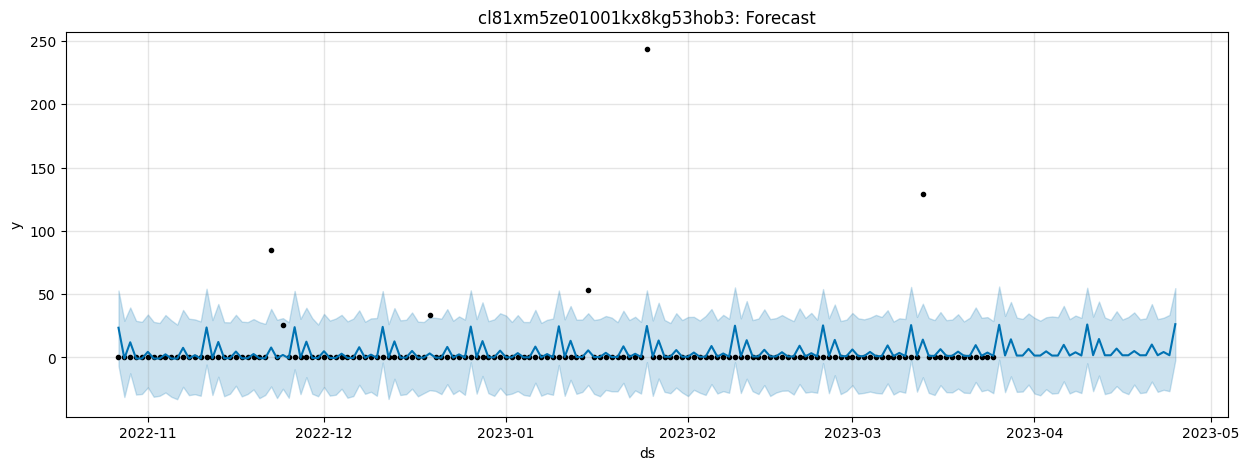

13:08:43 - cmdstanpy - INFO - Chain [1] start processing
13:08:43 - cmdstanpy - INFO - Chain [1] done processing
13:08:43 - cmdstanpy - INFO - Chain [1] start processing


Mean absolute error of 99.97528328959925


13:08:43 - cmdstanpy - INFO - Chain [1] done processing
13:08:43 - cmdstanpy - INFO - Chain [1] start processing
13:08:43 - cmdstanpy - INFO - Chain [1] done processing


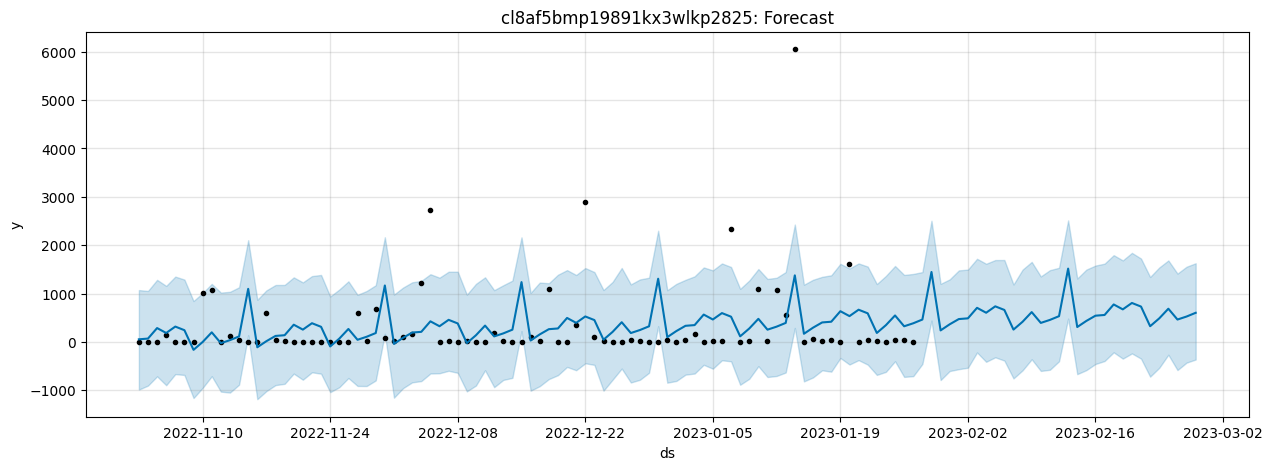

13:08:43 - cmdstanpy - INFO - Chain [1] start processing
13:08:44 - cmdstanpy - INFO - Chain [1] done processing
13:08:44 - cmdstanpy - INFO - Chain [1] start processing


Mean absolute error of 296.3470927730468


13:08:44 - cmdstanpy - INFO - Chain [1] done processing
13:08:44 - cmdstanpy - INFO - Chain [1] start processing
13:08:44 - cmdstanpy - INFO - Chain [1] done processing


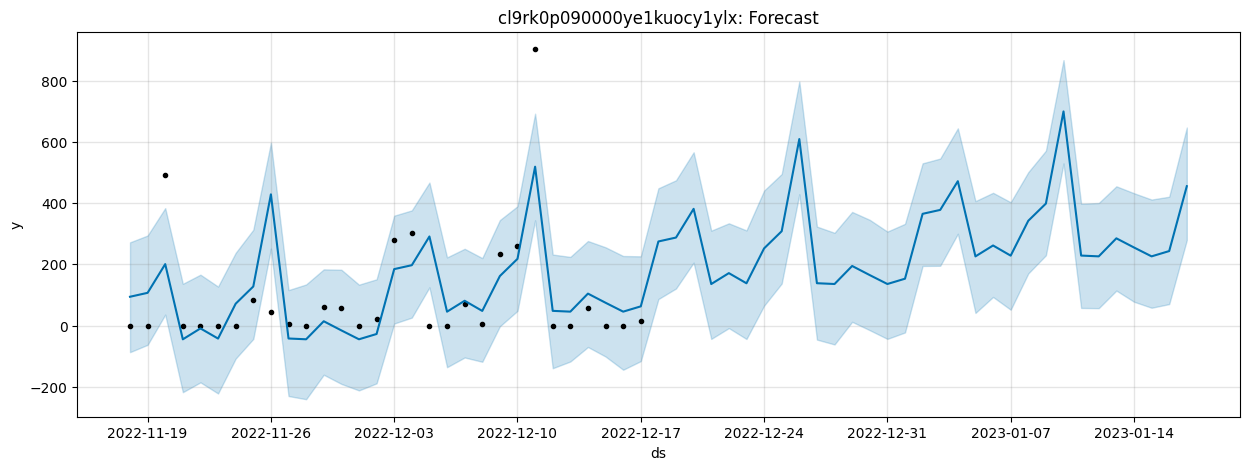

13:08:44 - cmdstanpy - INFO - Chain [1] start processing
13:08:44 - cmdstanpy - INFO - Chain [1] done processing
13:08:44 - cmdstanpy - INFO - Chain [1] start processing
13:08:44 - cmdstanpy - INFO - Chain [1] done processing
13:08:44 - cmdstanpy - INFO - Chain [1] start processing


Mean absolute error of 87.25464133310341


13:08:44 - cmdstanpy - INFO - Chain [1] done processing


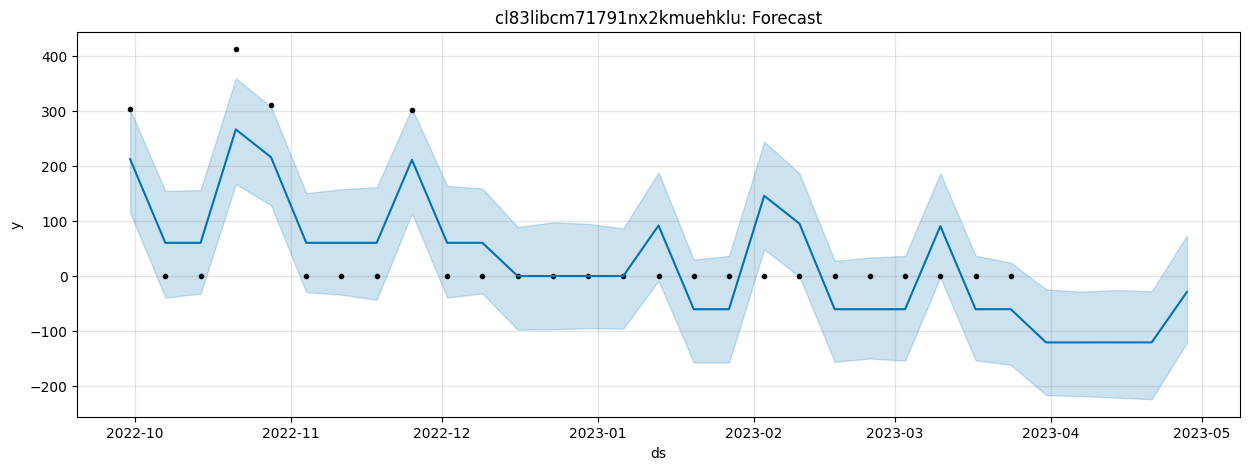

13:08:44 - cmdstanpy - INFO - Chain [1] start processing
13:08:44 - cmdstanpy - INFO - Chain [1] done processing
13:08:45 - cmdstanpy - INFO - Chain [1] start processing
13:08:45 - cmdstanpy - INFO - Chain [1] done processing
13:08:45 - cmdstanpy - INFO - Chain [1] start processing


Mean absolute error of 100.0


13:08:45 - cmdstanpy - INFO - Chain [1] done processing


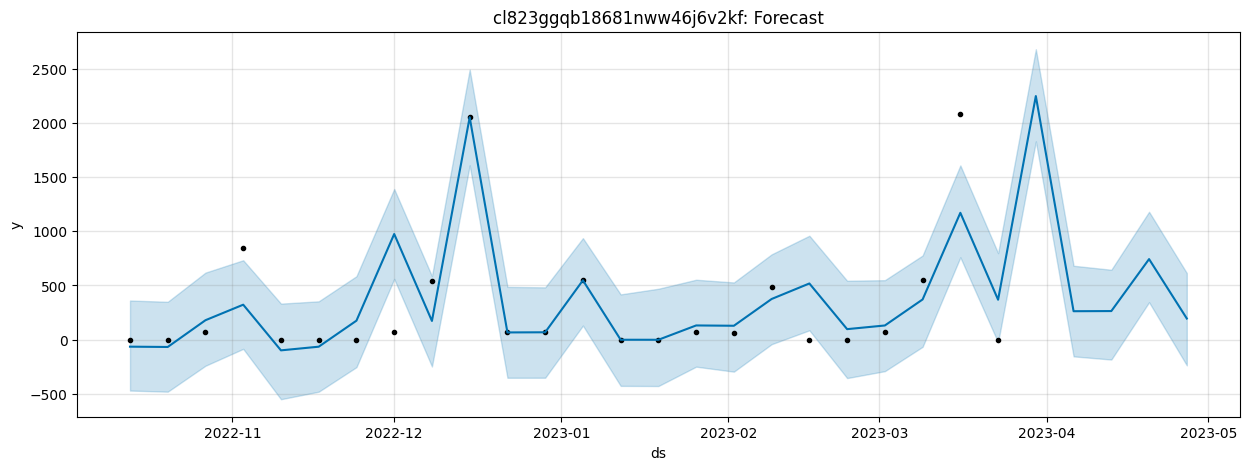

Mean absolute error of 602.1343707800617


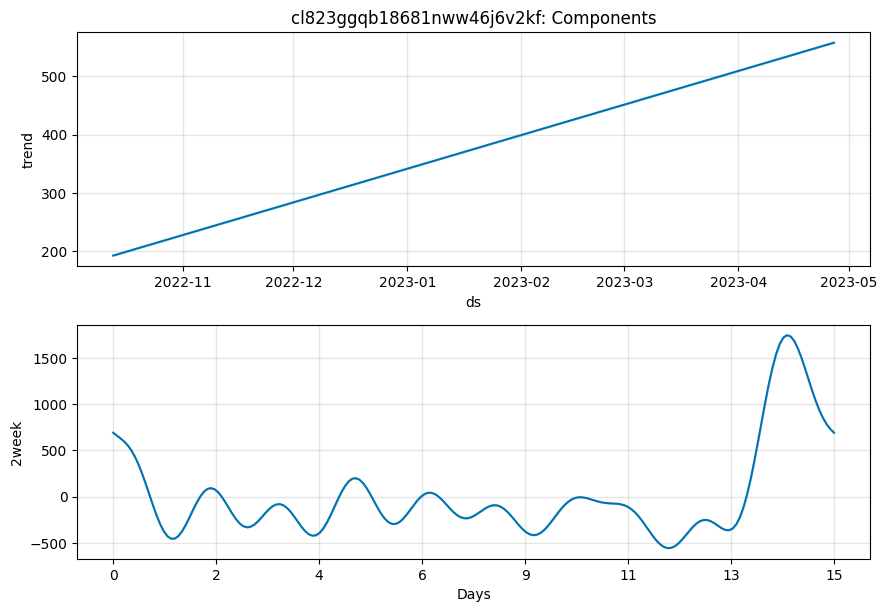

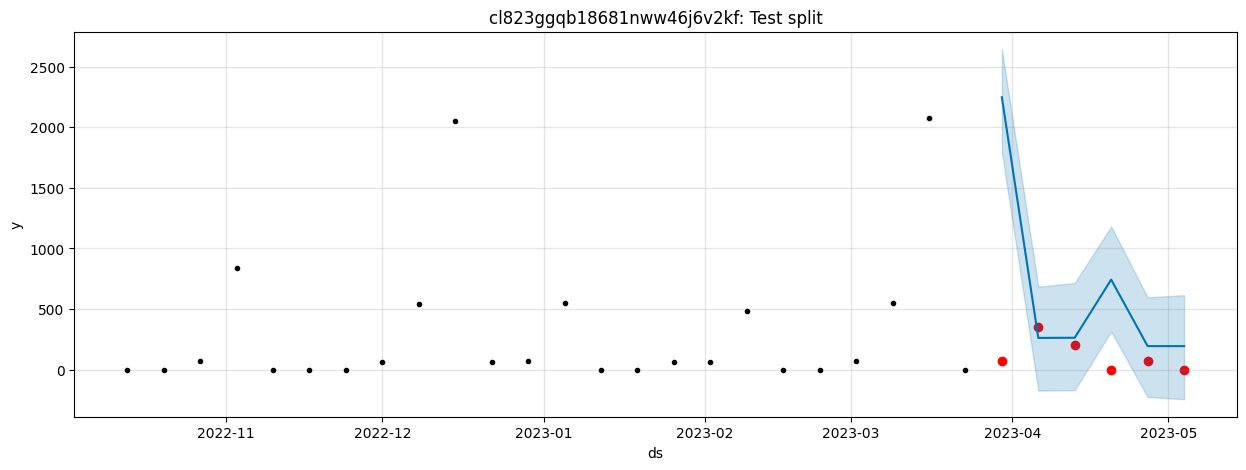

13:08:45 - cmdstanpy - INFO - Chain [1] start processing
13:08:45 - cmdstanpy - INFO - Chain [1] done processing
13:08:45 - cmdstanpy - INFO - Chain [1] start processing
13:08:45 - cmdstanpy - INFO - Chain [1] done processing
13:08:45 - cmdstanpy - INFO - Chain [1] start processing
13:08:45 - cmdstanpy - INFO - Chain [1] done processing


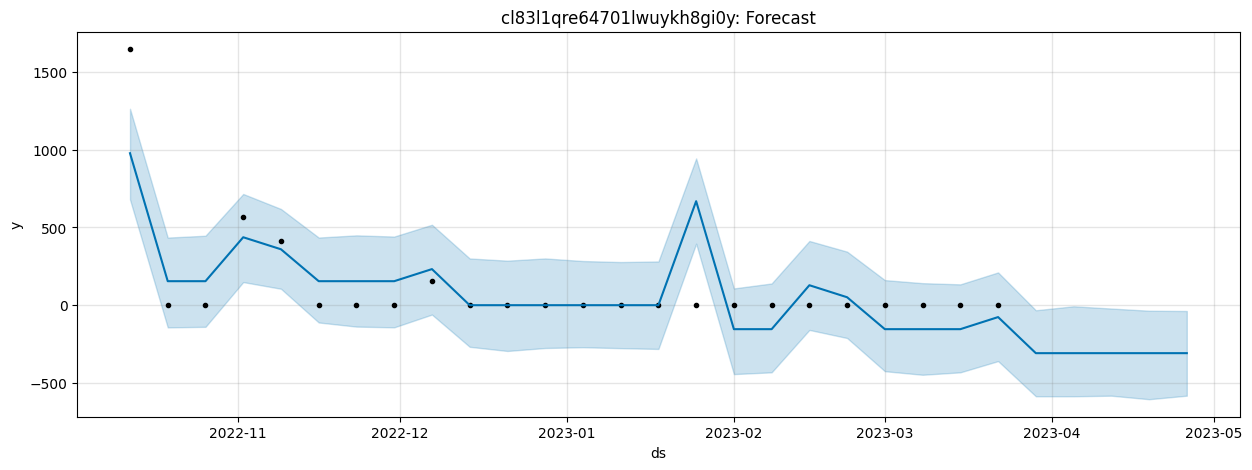

13:08:46 - cmdstanpy - INFO - Chain [1] start processing
13:08:46 - cmdstanpy - INFO - Chain [1] done processing
13:08:46 - cmdstanpy - INFO - Chain [1] start processing
13:08:46 - cmdstanpy - INFO - Chain [1] done processing
13:08:46 - cmdstanpy - INFO - Chain [1] start processing


Mean absolute error of 100.0


13:08:46 - cmdstanpy - INFO - Chain [1] done processing


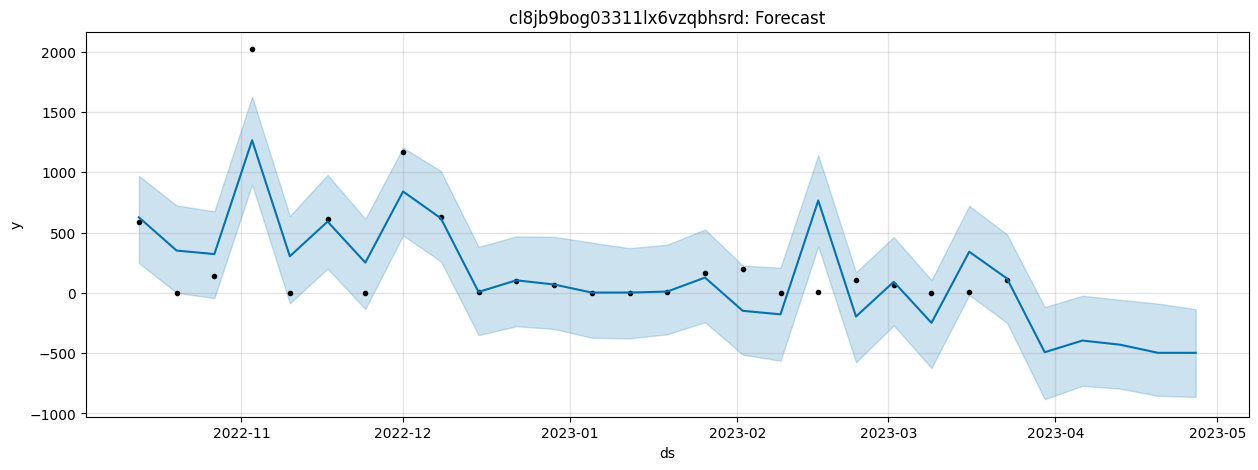

13:08:46 - cmdstanpy - INFO - Chain [1] start processing
13:08:46 - cmdstanpy - INFO - Chain [1] done processing
13:08:46 - cmdstanpy - INFO - Chain [1] start processing
13:08:46 - cmdstanpy - INFO - Chain [1] done processing
13:08:46 - cmdstanpy - INFO - Chain [1] start processing
13:08:46 - cmdstanpy - INFO - Chain [1] done processing


Mean absolute error of 3423.6874718670174


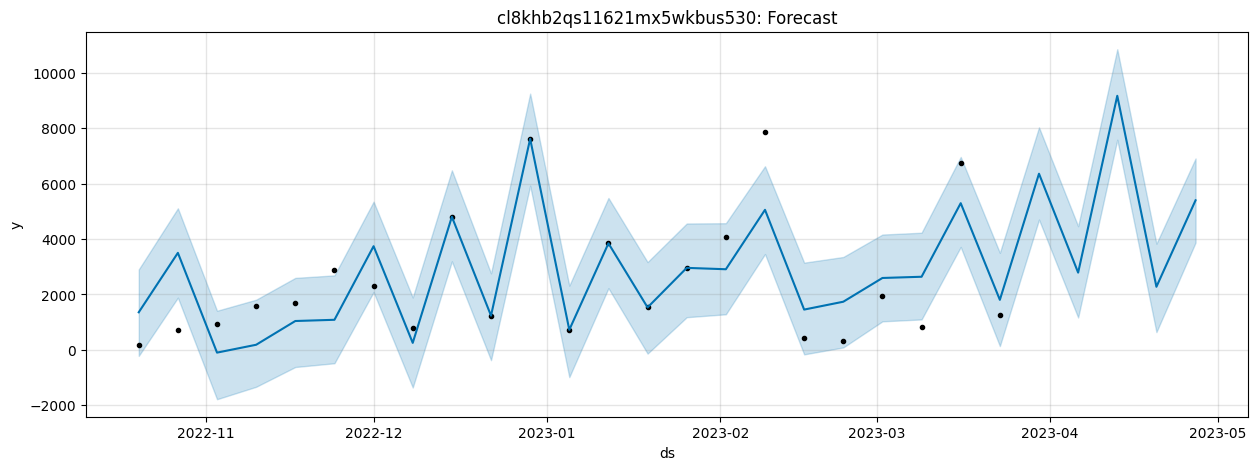

13:08:46 - cmdstanpy - INFO - Chain [1] start processing
13:08:47 - cmdstanpy - INFO - Chain [1] done processing
13:08:47 - cmdstanpy - INFO - Chain [1] start processing
13:08:47 - cmdstanpy - INFO - Chain [1] done processing
13:08:47 - cmdstanpy - INFO - Chain [1] start processing
13:08:47 - cmdstanpy - INFO - Chain [1] done processing


Mean absolute error of 155.77092604002806


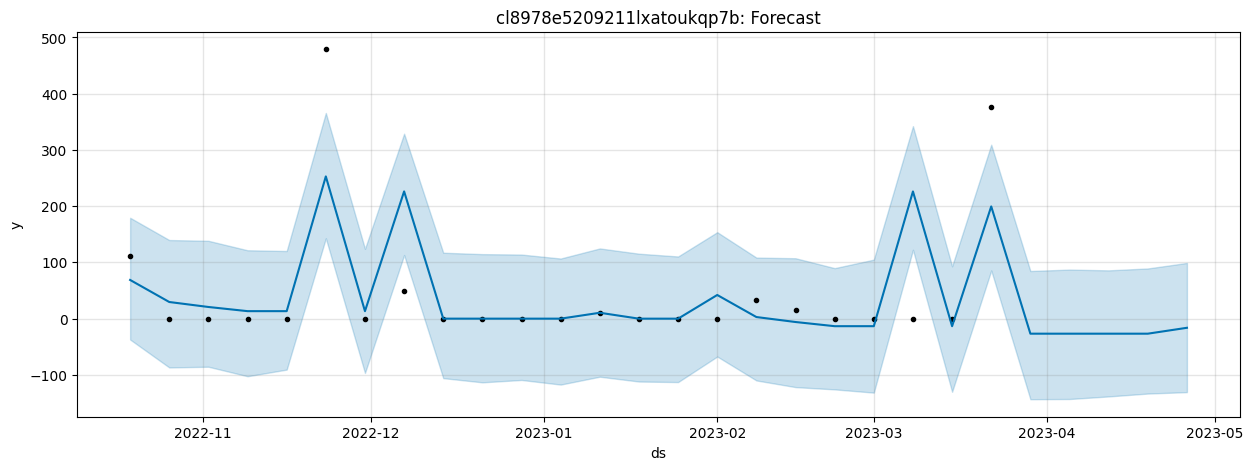

13:08:47 - cmdstanpy - INFO - Chain [1] start processing
13:08:47 - cmdstanpy - INFO - Chain [1] done processing
13:08:47 - cmdstanpy - INFO - Chain [1] start processing


Mean absolute error of 114.8599116701515


13:08:47 - cmdstanpy - INFO - Chain [1] done processing
13:08:47 - cmdstanpy - INFO - Chain [1] start processing
13:08:47 - cmdstanpy - INFO - Chain [1] done processing


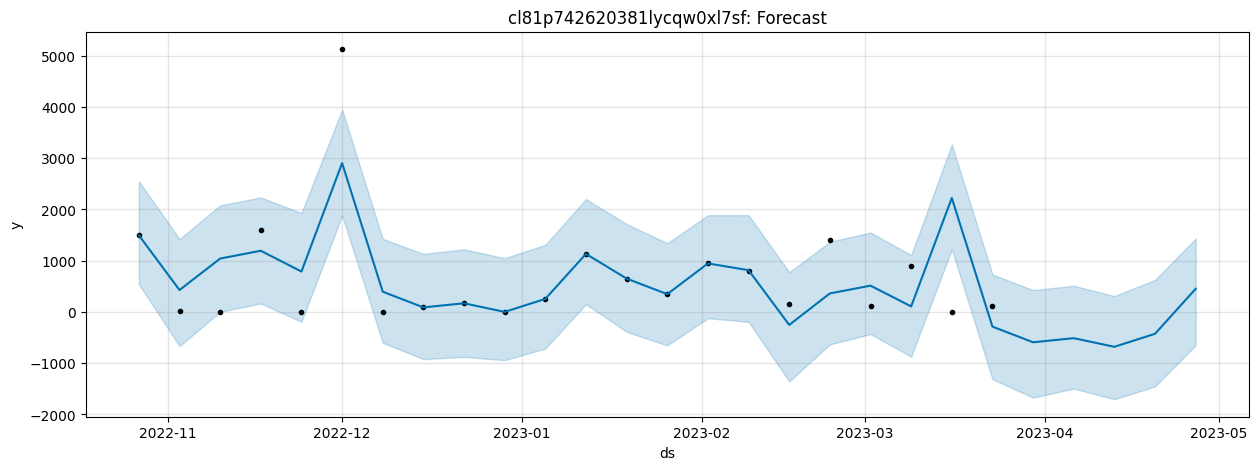

13:08:48 - cmdstanpy - INFO - Chain [1] start processing
13:08:48 - cmdstanpy - INFO - Chain [1] done processing
13:08:48 - cmdstanpy - INFO - Chain [1] start processing
13:08:48 - cmdstanpy - INFO - Chain [1] done processing
13:08:48 - cmdstanpy - INFO - Chain [1] start processing


Mean absolute error of 182.89394664811252


13:08:48 - cmdstanpy - INFO - Chain [1] done processing


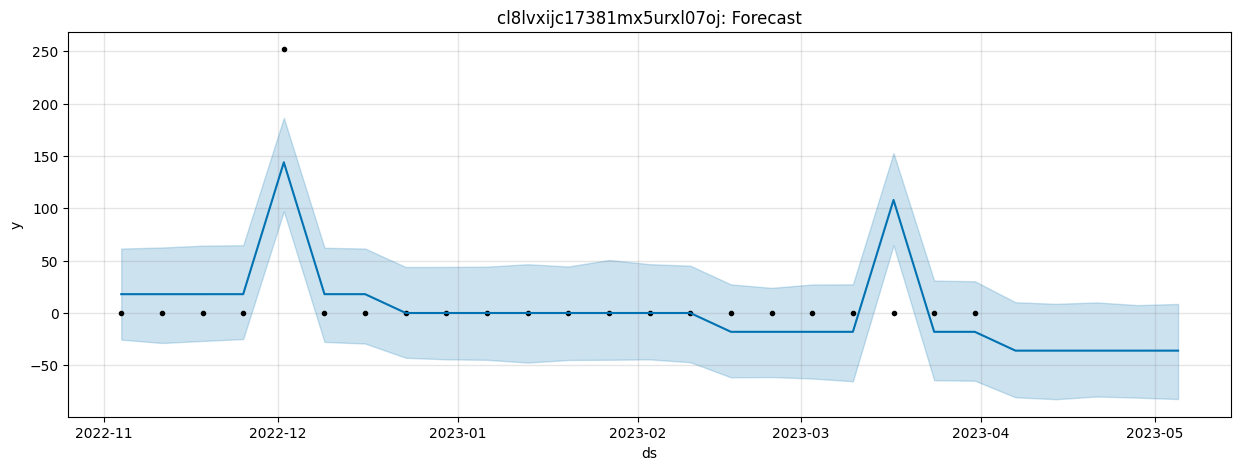

13:08:48 - cmdstanpy - INFO - Chain [1] start processing
13:08:48 - cmdstanpy - INFO - Chain [1] done processing
13:08:48 - cmdstanpy - INFO - Chain [1] start processing
13:08:48 - cmdstanpy - INFO - Chain [1] done processing
13:08:48 - cmdstanpy - INFO - Chain [1] start processing


Mean absolute error of 100.0


13:08:48 - cmdstanpy - INFO - Chain [1] done processing


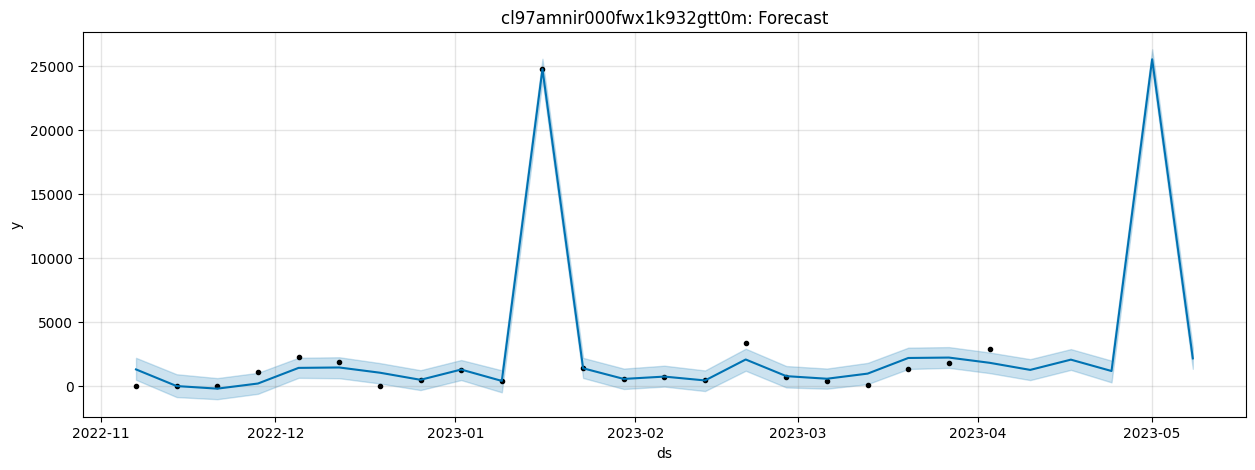

13:08:49 - cmdstanpy - INFO - Chain [1] start processing
13:08:49 - cmdstanpy - INFO - Chain [1] done processing
13:08:49 - cmdstanpy - INFO - Chain [1] start processing


Mean absolute error of 1443.575980897923


13:08:54 - cmdstanpy - INFO - Chain [1] done processing
13:08:54 - cmdstanpy - INFO - Chain [1] start processing
13:08:58 - cmdstanpy - INFO - Chain [1] done processing


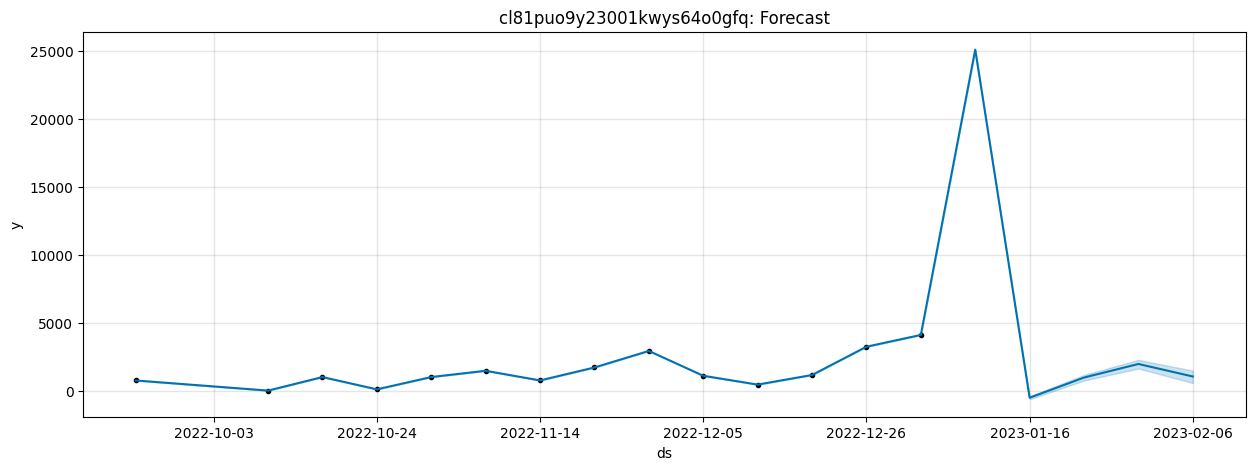

Mean absolute error of 1074.5906597492678


In [16]:
fit_details = False
for business in target_business["business_id"].to_list():
    if business=='cl823ggqb18681nww46j6v2kf': 
        fit_details=True
    prophet_business_models(business, statements_df_target_business, fit_details)
    fit_details = False

## Part 3: Systematizing and Reporting

## Task tracker
* Inspect 

## Weekly report template
* 